# Independent Component Analysis and Principal Component Analysis

In [22]:
import numpy as np                       # mathematical methods
import pandas as pd
from scipy import stats                  # statistical methods
from matplotlib import pyplot as plt     # plotting methods
from scipy import stats                  # statistic methods
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
%matplotlib inline

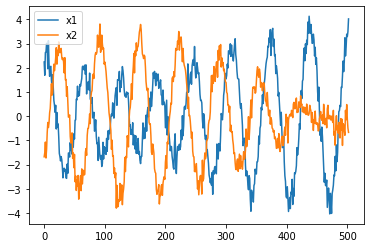

In [2]:
# load data
X = np.loadtxt('data/waves.txt')
index = np.arange(X.shape[0])
x1 = X[:,0]
x2 = X[:,1]
plt.plot(index,x1,label='x1')
plt.plot(index,x2,label='x2')
plt.legend();

"expectation" values: m0 = 0.01358 and m1 = -0.00592
"co/variances": 
[[ 3.59984334 -1.3235423 ]
 [-1.3235423   3.12562977]]
expectation(x1^2)=3.59984 x expectation(x2^2)=3.12563 gives 11.25178 
                which is != expectation(x1^2*x2^2)          6.60643


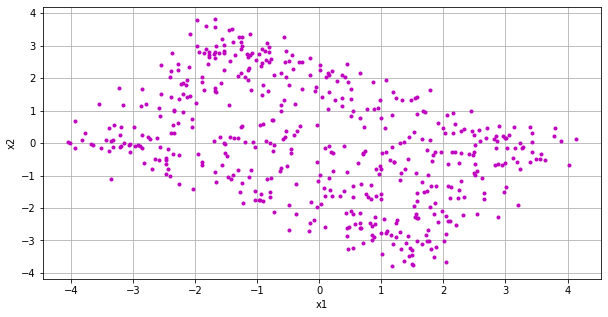

In [3]:
# are x1 and x2 independent? No, one sees a dependency between the variables in the plot 
# and the second moment does not factorize
print('"expectation" values: m0 = {:.5f} and m1 = {:.5f}'.format(X[:,0].mean(), X[:,1].mean()))
Cp = np.cov(X.T)
print('"co/variances": \n{}'.format(Cp, ddof=0))
# moment
E22 = 1/X.shape[0] * (X[:,0]**2*X[:,1]**2).sum()
print('expectation(x1^2)={:.5f} x expectation(x2^2)={:.5f} gives {:.5f} \n \
               which is != expectation(x1^2*x2^2)          {:.5f}'
     .format(Cp[0,0], Cp[1,1], Cp[0,0]*Cp[1,1], E22))

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.grid(True)
ax.plot(x1, x2, 'm.')
ax.set_xlabel('x1')
ax.set_ylabel('x2');

## PCA does decorrelates but does not recover independence

"expectation" values: m0 = -0.00000 and m1 = 0.00000
"co/variances": 
[[4.70734946 0.        ]
 [0.         2.01812366]]
expectation(z1^2)=4.70735 x expectation(z2^2)=2.01812 gives 9.50001 
                which is != expectation(z1^2*z2^2)          9.57000


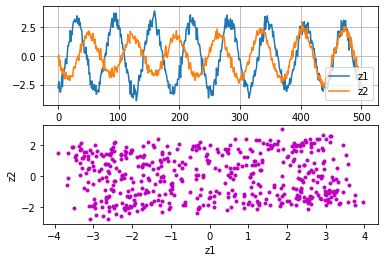

In [7]:
# perform PCA 
C = np.cov(X)
pca = PCA(n_components = 2)
pca.fit(X)
W = pca.components_
# project to PCs
Z = pca.transform(X)
# check if second moment factorizes
print('"expectation" values: m0 = {:.5f} and m1 = {:.5f}'.format(Z[:,0].mean(), Z[:,1].mean()))
Cp = np.cov(Z.T)
print('"co/variances": \n{}'.format(Cp, ddof=0))
# moment
E22 = 1/Z.shape[0] * (Z[:,0]**2*Z[:,1]**2).sum()
print('expectation(z1^2)={:.5f} x expectation(z2^2)={:.5f} gives {:.5f} \n \
               which is != expectation(z1^2*z2^2)          {:.5f}'
     .format(Cp[0,0], Cp[1,1], Cp[0,0]*Cp[1,1], E22))
# plot projected data
z1 = Z[:,0]
z2 = Z[:,1]
fig, axes = plt.subplots(2,1)
axes[0].plot(index,z1,label='z1')
axes[0].plot(index,z2,label='z2')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(z1, z2, 'm.')
axes[1].set_xlabel('z1')
axes[1].set_ylabel('z2');

## ICA to uncover independent sources

Kurtosis of original data  x1=-0.92  x2=-0.75 
    and of decorrelated data  z1=-1.38  z2=-1.29


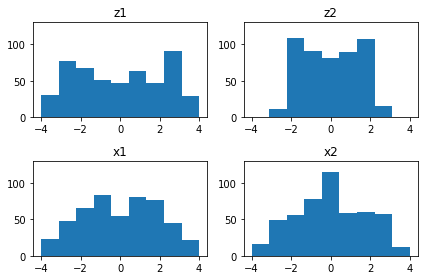

In [9]:
# check kurtosis of original and decorrelated data (PCA results)
# PCA tries to find non-normal signals
# as kurtosis is negative for all and larger for transformed data, PCA successfully decorrelated the data
k1, k2, k3, k4 = (stats.kurtosis(x1),stats.kurtosis(x2),stats.kurtosis(z1),stats.kurtosis(z2))
print('Kurtosis of original data  x1={:.2f}  x2={:.2f} \n    and of decorrelated data  z1={:.2f}  z2={:.2f}'
      .format(k1, k2, k3, k4))
bins = np.linspace(-4, 4, 10)
fig, axes = plt.subplots(2,2)
zxs = [z1, z2, x1, x2]
for ax, data, label in zip(axes.flatten(), zxs,['z1','z2','x1','x2']):
    ax.hist(data, bins)
    ax.set_ylim(0,130)
    ax.set_title(label)
plt.tight_layout()
plt.show();

maximum kurtosis for X = -0.44 @ 11.5°
maximum kurtosis for Z = -0.44 @ 121.5°


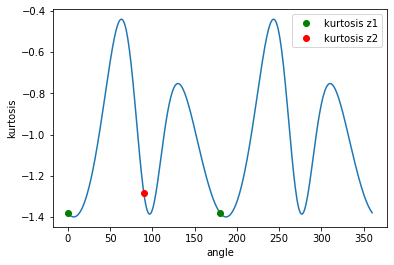

In [16]:
# projection pursuit
def kurtosis_step(phi,data):
    '''
    calculates kurtosis and its x- and y-components for one angle phi
    input: phi
    output: (kurtosis, kurtosis-x, kurtosis-y)
    '''
    cos_phi, sin_phi = np.cos(phi), np.sin(phi)
    testvector = cos_phi * data[0] + sin_phi * data[1]
    kurt = stats.kurtosis(testvector)
    return kurt, cos_phi * kurt, sin_phi * kurt
nst = 360
kurtsX, kx1, kx2 = np.asarray([kurtosis_step(p,X.T) for p in np.linspace(0, 2 * np.pi, nst+1)]).T
kmaxindexX = np.argmax(kurtsX)
kmaxX = kurtsX[kmaxindexX]
print('maximum kurtosis for X = {:.2f} @ {:.1f}°'.format(kurtsX[kmaxindexX], kmaxindexX/2))
kurtsZ, kz1, kz2 = np.asarray([kurtosis_step(p,Z.T) for p in np.linspace(0, 2 * np.pi, nst+1)]).T
kmaxindexZ = np.argmax(kurtsZ)
kmaxZ = kurtsZ[kmaxindexZ]
print('maximum kurtosis for Z = {:.2f} @ {:.1f}°'.format(kurtsZ[kmaxindexZ], kmaxindexZ/2))
# kurtosis in relation to projection angle
plt.plot(np.arange(nst+1),kurtsZ)
plt.xlabel('angle')
plt.ylabel('kurtosis')
i_k3 = np.argwhere(kurtsZ==k3)
i_k4 = np.argwhere(kurtsZ==k4)
plt.plot(i_k3.flatten(),np.full(len(i_k3),k3),'go',label='kurtosis z1')
plt.plot(i_k4.flatten(),np.full(len(i_k4),k4),'ro',label='kurtosis z2')
plt.legend();

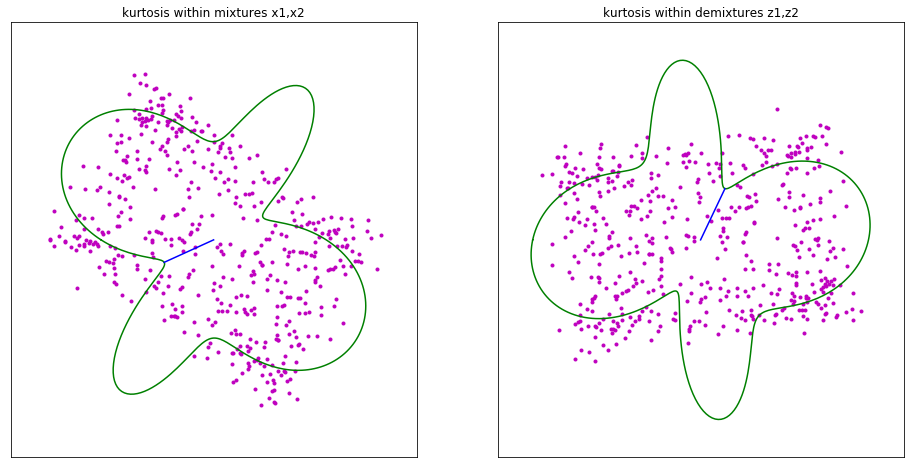

In [11]:
scalex = 3.
scalez = 3.
fig,axes = plt.subplots(1,2,figsize=(16, 8),sharex=True,sharey=True)
axes[0].set_title('kurtosis within mixtures x1,x2')
axes[0].plot(x1, x2, 'm.')
axes[0].plot(scalex*kx1,scalex*kx2,'g-')
axes[0].plot((0., scalex*kx1[kmaxindexX]),(0., scalex*kx2[kmaxindexX]), 'b-')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_title('kurtosis within demixtures z1,z2')
axes[1].plot(z1, z2, 'm.')
axes[1].plot(scalez*kz1,scalez*kz2,'g-')
axes[1].plot((0., scalez*kz1[kmaxindexZ]),(0., scalez*kz2[kmaxindexZ]), 'b-')
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.xlim(-5,5)
plt.ylim(-5,5);

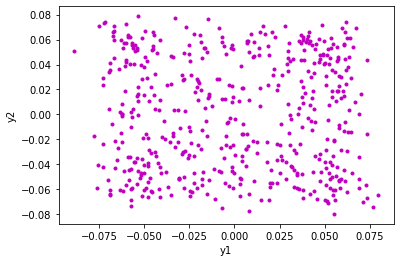

In [19]:
# ICA using sklearn
ica = FastICA(n_components=2)
Y = ica.fit_transform(X)
W = ica.components_
plt.plot(Y[:,0],Y[:,1],'m.')
plt.xlabel('y1')
plt.ylabel('y2');

"expectation" values: m0 = -0.00000 and m1 = -0.00000
"co/variances": 
[[1.99203187e-03 1.10579983e-19]
 [1.10579983e-19 1.99203187e-03]]
expectation(y1^2)=0.00199 x expectation(y2^2)=0.00199 gives 0.00000 
                which is = expectation(y1^2*y2^2)          0.00000


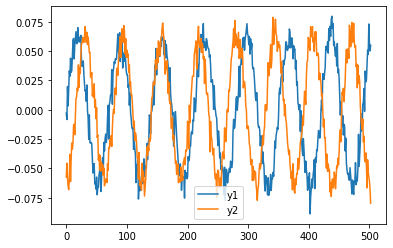

In [21]:
# check if ICA uncovers independent sources
print('"expectation" values: m0 = {:.5f} and m1 = {:.5f}'.format(Y[:,0].mean(), Y[:,1].mean()))
Cp = np.cov(Y.T)
print('"co/variances": \n{}'.format(Cp, ddof=0))
# moment
E22 = 1/X.shape[0] * (Y[:,0]**2*Y[:,1]**2).sum()
print('expectation(y1^2)={:.5f} x expectation(y2^2)={:.5f} gives {:.5f} \n \
               which is = expectation(y1^2*y2^2)          {:.5f}'
     .format(Cp[0,0], Cp[1,1], Cp[0,0]*Cp[1,1], E22))

plt.plot(index,Y[:,0],label='y1')
plt.plot(index,Y[:,1],label='y2')
plt.legend();

## PCA vs ICA

(1000, 1024)


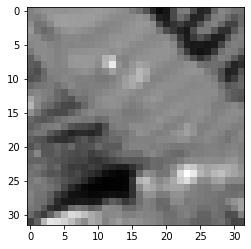

In [24]:
# get data
Xraw = (pd.read_csv('data/natural-scenes-data.csv', sep=',', header=None)).values
print(Xraw.shape)
plt.imshow(Xraw[801].reshape(32, 32), cmap="gray");

16000


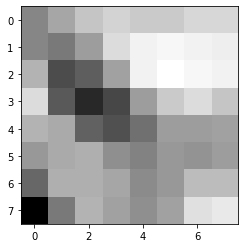

In [25]:
X = Xraw.reshape(1000, 4, 8, 4, 8)           # make 3D temporarily 5D
X = np.rollaxis(X, 3, 2).reshape(-1, 8 * 8)  # and recollect right axes, -1 means auto scale
print(X.shape[0])
plt.imshow(X[4*4*801].reshape(8, 8), cmap="gray");  # show corner from 6th image

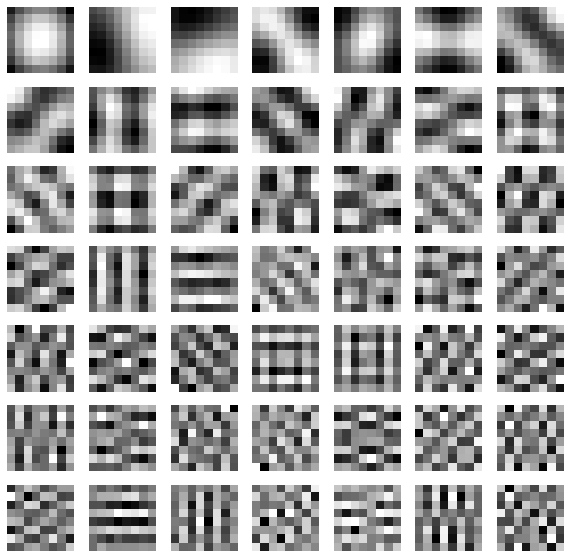

In [26]:
# perform PCA
pca = PCA(n_components = 49)
pca.fit(X)
plt.figure(figsize=(10, 10))
for i, f in enumerate(pca.components_):
    plt.subplot(7, 7, i+1)                    # draw images in 7x7 grid
    plt.imshow(f.reshape(8, 8), cmap="gray")
    plt.axis("off")

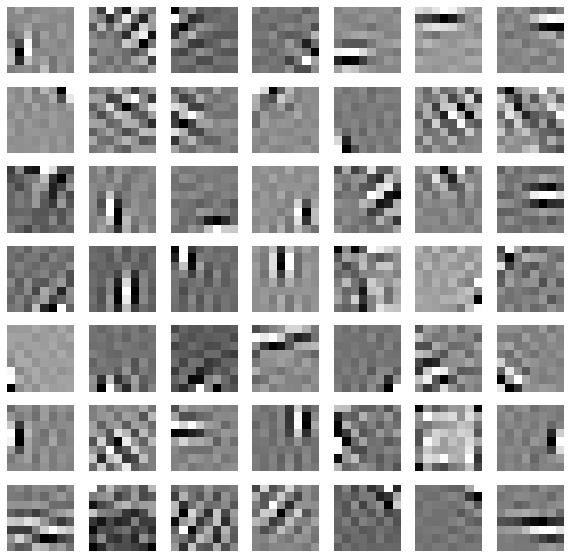

In [27]:
# perform ICA
ica = FastICA(n_components = 49)
ica.fit(X)
plt.figure(figsize=(10, 10))
for i, f in enumerate(ica.components_):
    plt.subplot(7, 7, i+1)                    # draw images in 7x7 grid
    plt.imshow(f.reshape(8, 8), cmap="gray")
    plt.axis("off")